# trento3D产生的 d + Au @200Gev碰撞能量下的输出数据，查看处理后的文件

## 主要是拆分TRENTO的数据

### 1、处理分割数据
### 2、计算查看每个事件的熵密度分布
### 3、计算查看光滑的熵密度分布

### 把TRENTo产生的dat文件，按照事件进行分割成以 event_i 文件夹 ，
### 每个文件夹 event_i 中保存三个数据文件：
### 保存入射核以及靶核中参与碰撞的核子在横平面上的坐标(x, y)，以及中心快度处横平面上的碰撞的信息

### TRENTo输出的信息

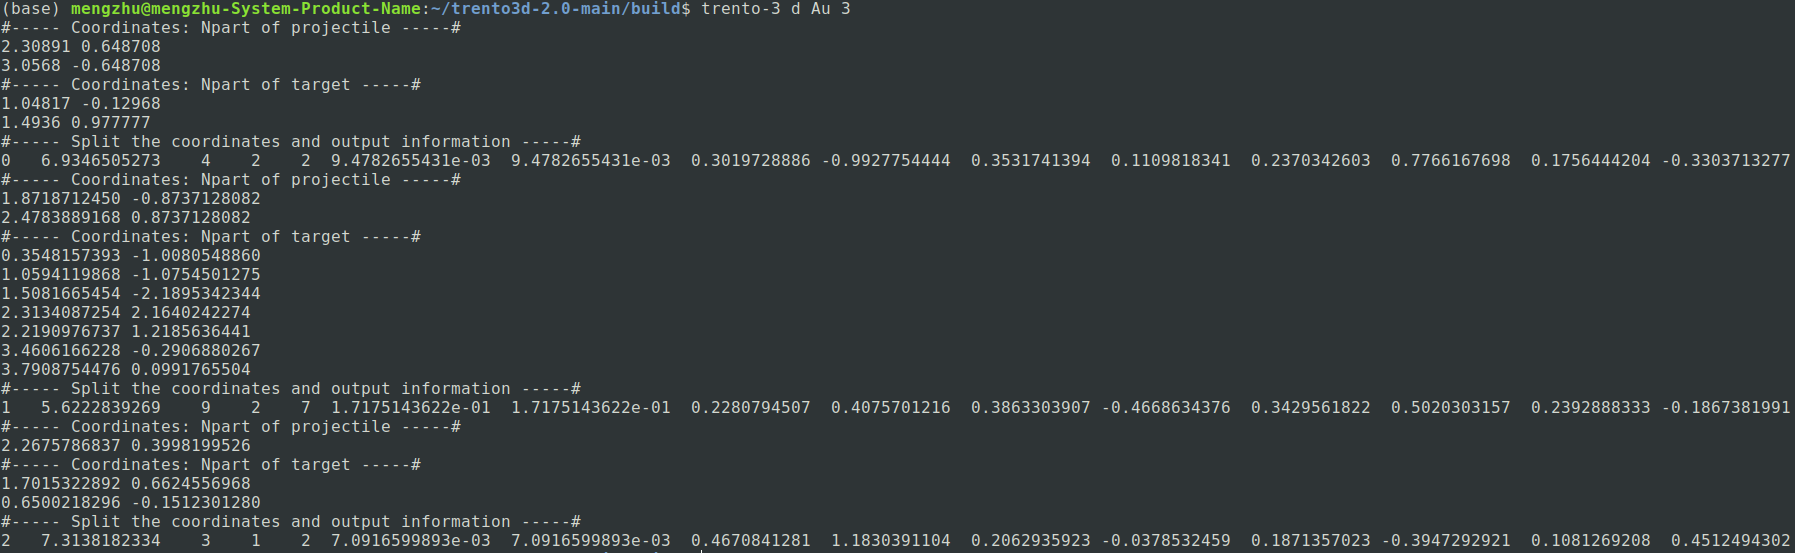

# 一、处理TRENTo产生的信息，将输出的信息分割保存

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from IPython.display import Image

import os
from tqdm import tqdm

import mplhep as hep
hep.style.use('ATLAS')

In [2]:
def split_and_save_data(input_file_path, output_dir):
    """
    Splits data from the input file into separate events and saves them in the specified output directory.

    Parameters:
    input_file_path (str): Path to the input data file.
    output_dir (str): Path to the directory where output files will be saved.

    Returns:
    None
    """
    # Check if output directory already exists
    if os.path.exists(output_dir):
        print(f"The directory '{output_dir}' already exists.")
        print("Please check the directory and its contents before running the program again.")
        return

    # Create main directory for output files
    os.makedirs(output_dir)

    # Read data from the input file
    with open(input_file_path, 'r') as file:
        data = file.read()

    # Split the data into events
    events = data.strip().split("#----- Coordinates: Npart of projectile -----#")[1:]

    # Function to filter valid coordinate lines
    def filter_coordinates(data):
        lines = data.split('\n')
        valid_lines = [line for line in lines if line.strip() and len(line.split()) == 2]
        return '\n'.join(valid_lines)

    # Write each event to separate files
    for i, event in enumerate(events):
        # Create subdirectory for each event
        event_dir = os.path.join(output_dir, f'event_{i}')
        os.makedirs(event_dir)
        
        parts = event.split("#----- Coordinates: Npart of target -----#")
        projectile_data = filter_coordinates(parts[0].strip())
        target_and_split = parts[1].split("#----- Split the coordinates and output information -----#")
        target_data = filter_coordinates(target_and_split[0].strip())
        split_data = target_and_split[1].strip()

        with open(os.path.join(event_dir, 'position_of_projectile.dat'), 'w') as file:
            file.write(projectile_data)
        with open(os.path.join(event_dir, 'position_of_target.dat'), 'w') as file:
            file.write(target_data)
        with open(os.path.join(event_dir, 'information_of_output.dat'), 'w') as file:
            file.write(split_data)

        print(f"Data for event_{i} saved to {event_dir}/projectile.dat, target.dat, and split.dat")

    print("All events have been saved to separate files in the specified output directory.")




### 对TRENTo-3d 的输出信息进行分割并保存,得到如下的结果

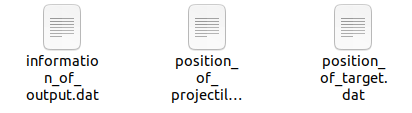

In [3]:
# Example usage
def split_and_save(HWF_or_DWF='HWF'):
#     disk_2T = '74e6f585-9c67-40c0-a5e9-89fb98e77bab'
    input_file_path = f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/trento3d_{HWF_or_DWF}_d_Au_ncoll_50000.dat'
    output_dir = f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/information_of_d_Au_collision'
    
    # Check if output directory already exists
    if os.path.exists(output_dir):
        print(f"The directory '{output_dir}' already exists.\n")
        print("Please check the directory and its contents before running the program again.")
        print('\n')
    else:
        split_and_save_data(input_file_path, output_dir)
    

In [4]:
split_and_save(HWF_or_DWF='HWF')

The directory '/media/mengzhu/west16/d_Au_work/d_Au_HWF/information_of_d_Au_collision' already exists.

Please check the directory and its contents before running the program again.




# 二、根据公式的形式定义相应的函数，实现对二维熵密度分布的计算查看
# 我们可以查看熵密度的分布情况，并且将分布情况的图片保存在制定文件目录

## 方法：
## 处理入射核和靶核的能量密度分布：参与碰撞的粒子看成高斯包在各个格点上进行求和
## 计算二维熵密度分布，画图查看

### $$
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta)\left[\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right]\\
&+f_R(\eta)\left[\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right]\\
&+ f_{plat}(\eta)\left[\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right]^{\beta}
\end{split}
$$

### $$f_{plat}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为停留在左侧的d核的纵向能量分布以及二维能量密度分布；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为停留在左侧的Au核的纵向能量分布以及二维能量密度分布

### 将参与碰撞的核子近似成三维高斯波包，以核子的位置为中心展开，取波包的 $\sigma=1$，用$5fm$的半径去截断波包，在$x,y$ in $(−16,16)$的平面坐标中，划分成规格(200,200)的格子，计算每个事件中所有参与碰撞的$N_{part}$的粒子在格点上的高斯值，并叠加，作为熵密度分布矩阵

In [5]:
def gaussian_sum(x_l, xi_list, sigma, distance_threshold=5):
    """
    Calculate the sum of Gaussian functions at a given grid point x_l, with a distance threshold.
    
    Parameters:
    x_l (numpy.ndarray): The grid point at which to evaluate the function, shape (2,).
    xi_list (list of numpy.ndarray): List of vectors where each vector is a center of a Gaussian, each of shape (2,).
    sigma (float): The standard deviation of the Gaussian functions.
    distance_threshold (float): The distance threshold beyond which the Gaussian contribution is ignored.
    
    Returns:
    float: The value of the sum of Gaussian functions at x_l.
    """
    sum_value = 0
    for xi in xi_list:
        distance = np.linalg.norm(x_l - xi)
        if distance <= distance_threshold:
            sum_value += np.exp(-np.sum((x_l - xi)**2) / (2 * sigma**2))
    return sum_value


def read_positions(file_path):
    """
    Read positions from a file and return them as a list of numpy arrays.
    
    Parameters:
    file_path (str): The path to the file containing the positions.
    
    Returns:
    list: A list of numpy arrays where each array is a position (x, y).
    """
    data = np.loadtxt(file_path)
    if data.ndim == 1:
        data = data.reshape(-1, 2)
    elif data.shape[1] != 2:
        raise ValueError("Each line in the file must contain exactly two values.")
    return [np.array([x, y]) for x, y in data]


def evaluate_gaussian_sum_on_grid(grid_points, xi_list, sigma):
    """
    Evaluate the Gaussian sum function on a grid of points.
    
    Parameters:
    grid_points (numpy.ndarray): The grid points on which to evaluate the function, shape (200, 200, 2).
    xi_list (list): A list of numpy arrays where each array is a center of a Gaussian.
    sigma (float): The standard deviation of the Gaussian functions.
    
    Returns:
    numpy.ndarray: The values of the Gaussian sum function on the grid, shape (200, 200).
    """
    grid_size = grid_points.shape[0]
    result = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            result[i, j] = gaussian_sum(grid_points[i, j], xi_list, sigma)
    return result


In [6]:
# create output path if it is not exist
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
# save entropy # (200, 200)        
def save_results(base_directory, filename, result):
    '''save entropy and return path of saving'''
    ensure_directory_exists(base_directory)
    filepath = os.path.join(base_directory, filename)
    np.savetxt(filepath, result)
    return filepath
        


In [7]:
def calculate_2D_entropy(event=0, sigma=1.0,HWF_or_DWF='HWF'):
    # File paths
    disk_2T = 'west16'
    input_base_path = f'/media/mengzhu/{disk_2T}/d_Au_work/d_Au_{HWF_or_DWF}/information_of_d_Au_collision/event_{event}'

    target_file_path = os.path.join(input_base_path, 'position_of_target.dat')
    proj_file_path = os.path.join(input_base_path, 'position_of_projectile.dat')
    
    # Read the targets and projectiles Coordinates(x, y) data from the files
    target_xi_list = read_positions(target_file_path)
    proj_xi_list = read_positions(proj_file_path)

    # Define the grid
    grid_size = 200
    x_range = np.linspace(-10, 10, grid_size)
    y_range = np.linspace(-10, 10, grid_size)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    grid_points = np.stack([x_grid, y_grid], axis=-1)  # Grid_points's Shape (200, 200, 2) 

    # Evaluate the function on the grid for target and projectile 
    target_result = evaluate_gaussian_sum_on_grid(grid_points, target_xi_list, sigma)
    proj_result = evaluate_gaussian_sum_on_grid(grid_points, proj_xi_list, sigma)

    return target_result, proj_result


### 横坐标是格子数的熵密度分布

In [8]:
def plot_2D_entropy(event=0, save_fig='false',HWF_or_DWF='HWF'):
    # Calculating 
    target_result, proj_result = calculate_2D_entropy(event=event, sigma=1.0, HWF_or_DWF=HWF_or_DWF)
    
    # Create output base path
    output_base_path = f'/home/mengzhu/mywork/d_Au_work/fig/'
    
    
    # Plotting
    title_fontsize=22 
    label_fontsize=18
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    c1 = ax1.imshow(proj_result, extent=(-100, 100, -100, 100), cmap='hot', aspect='auto')
    fig.colorbar(c1, ax=ax1, label='Gaussian Sum')
    ax1.set_title('The 2D Entropy Distribution of d', fontsize=label_fontsize)
    ax1.set_xlabel('X', fontsize=label_fontsize, ha='center')
    ax1.set_ylabel('Y', fontsize=label_fontsize, ha='center')
    ax1.set_aspect('equal')
    
    c2 = ax2.imshow(target_result, extent=(-100, 100, -100, 100), cmap='hot', aspect='auto')
    fig.colorbar(c2, ax=ax2, label='Gaussian Sum')
    ax2.set_title('The 2D Entropy Distribution of Au', fontsize=label_fontsize)
    ax2.set_xlabel('X', fontsize=label_fontsize, ha='center')
    ax2.set_ylabel('Y', fontsize=label_fontsize, ha='center')
    ax2.set_aspect('equal')

    # Adjust layout and title
    plt.tight_layout(rect=[0.05, 0, 0.95, 0.9])
    plt.suptitle(f'The 2D Entropy Distribution of d and Au at Event_{event} in {HWF_or_DWF} Condition', fontsize=title_fontsize)

    # Save the figure
    if save_fig in {'true', 'True'}:
        ensure_directory_exists(output_base_path)
        heatmap_out_path = os.path.join(output_base_path, f'heatmap_event_{event}_of_d_and_Au_in_{HWF_or_DWF}_condition.pdf' )
        plt.savefig(heatmap_out_path)
    
    # Show plot
    plt.show()


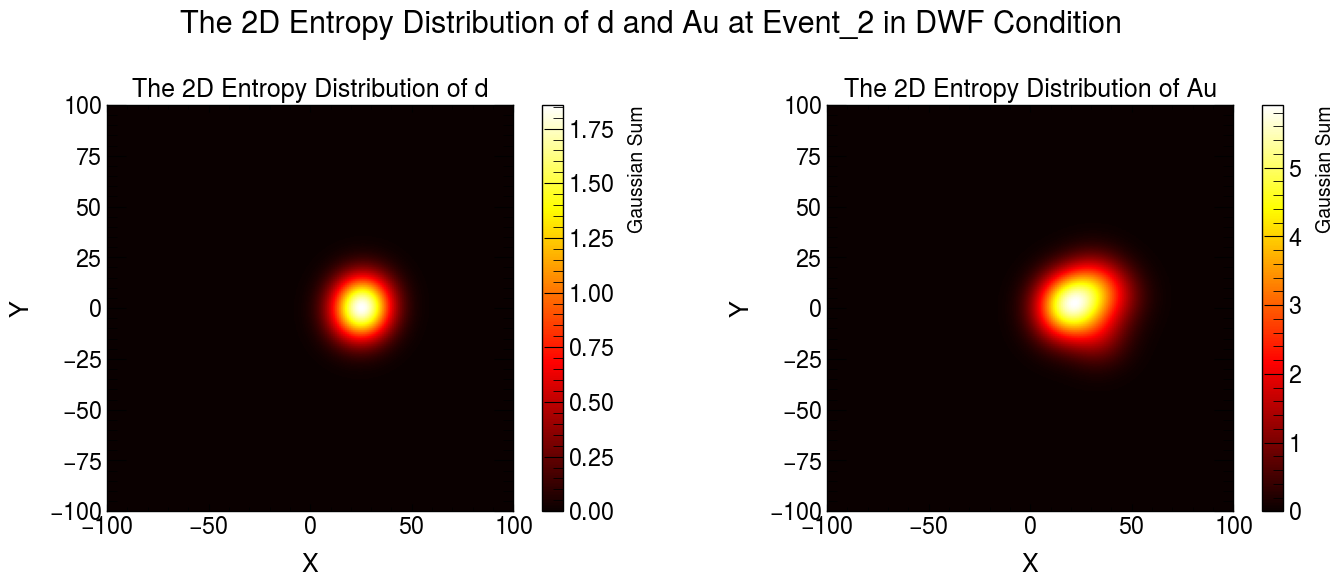

In [9]:
plot_2D_entropy(event=2, save_fig='gg', HWF_or_DWF='DWF')

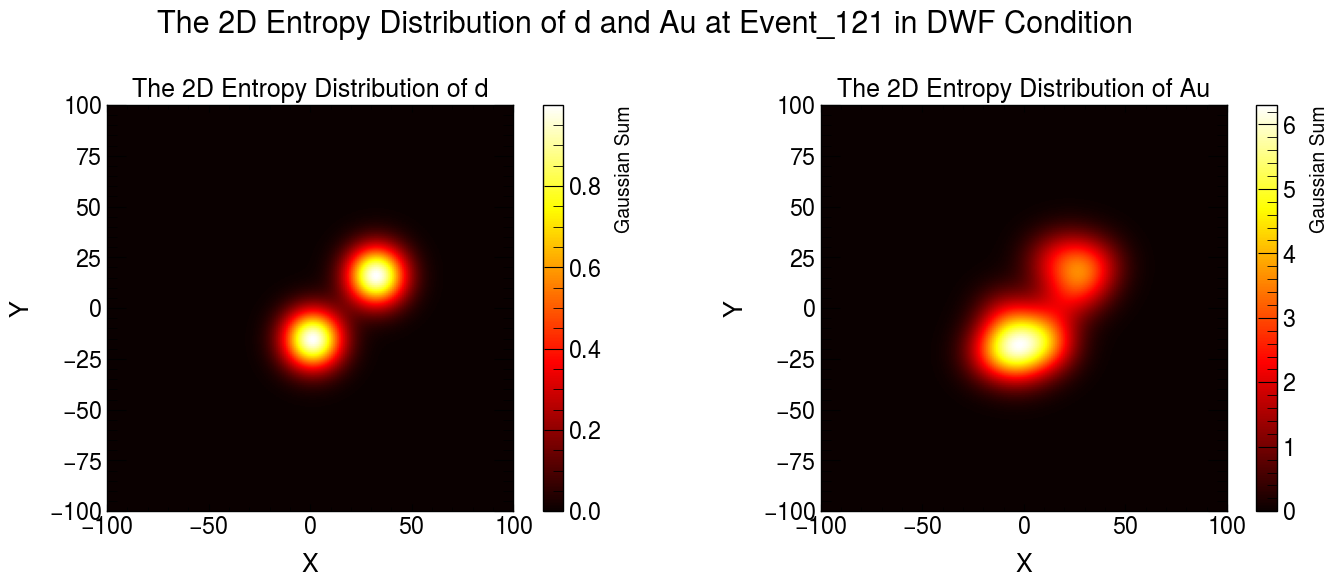

In [10]:
plot_2D_entropy(event=121, save_fig='gg', HWF_or_DWF='DWF')

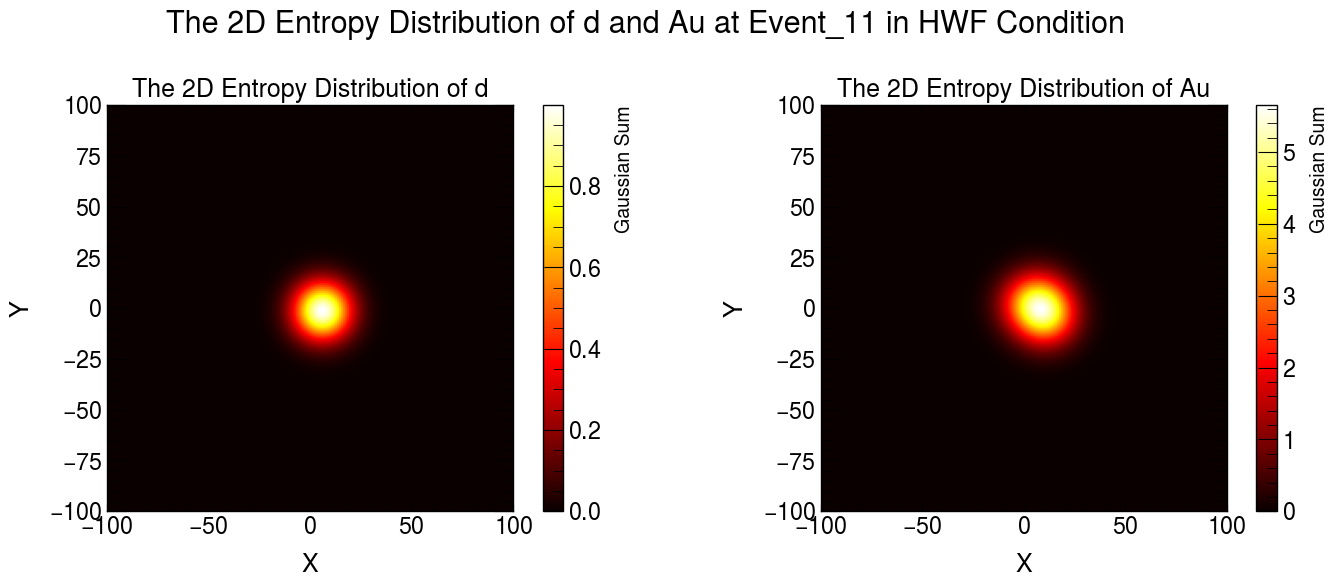

In [11]:
plot_2D_entropy(event=11, save_fig='gg', HWF_or_DWF='HWF')

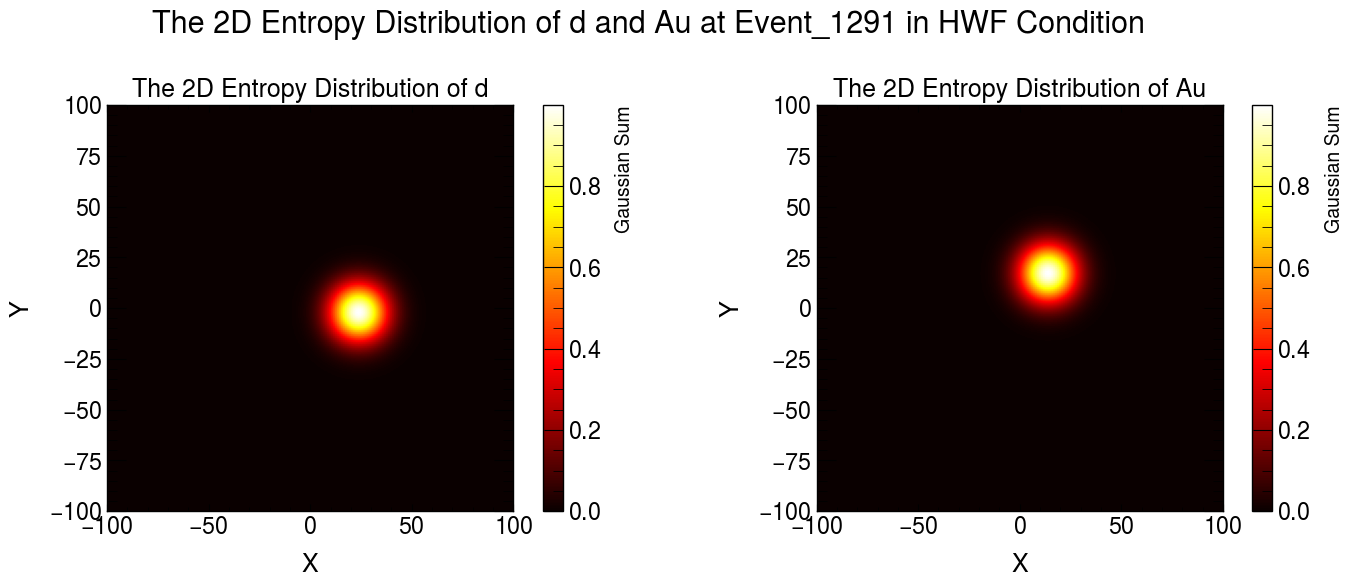

In [12]:
plot_2D_entropy(event=1291, save_fig='gg', HWF_or_DWF='HWF')

In [13]:
def plot_2D_entropy_part(event=0, save_fig='false', HWF_or_DWF='HWF'):
    # Calculating
    target_result, proj_result = calculate_2D_entropy(event=event, sigma=1.0, HWF_or_DWF=HWF_or_DWF)
    
    # Create output base path
    output_base_path = f'/home/mengzhu/mywork/d_Au_work/fig/'
    
    # Plotting
    title_fontsize = 22
    label_fontsize = 18
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calculate the indices for the desired range [-5, 5]
    original_range = [-10, 10]
    desired_range = [-5, 5]
    original_size = 200
    desired_size = int((desired_range[1] - desired_range[0]) / ((original_range[1] - original_range[0]) / original_size))
    
    # Calculate the start and end indices
    start_idx = int((desired_range[0] - original_range[0]) / ((original_range[1] - original_range[0]) / original_size))
    end_idx = start_idx + desired_size
    
    # Extract the desired range from the data
    proj_result = proj_result[start_idx:end_idx, start_idx:end_idx]
    target_result = target_result[start_idx:end_idx, start_idx:end_idx]
    
    # Calculate the global min and max values for the colorbar
    global_min = min(proj_result.min(), target_result.min())
    global_max = max(proj_result.max(), target_result.max())
    
    c1 = ax1.imshow(proj_result, extent=desired_range * 2, cmap='hot', aspect='auto', vmin=global_min, vmax=global_max)
    fig.colorbar(c1, ax=ax1, label='Gaussian Sum', format='%.1f')
    ax1.set_title('The 2D Entropy Distribution of d', fontsize=label_fontsize)
    ax1.set_xlabel('x  [fm]', fontsize=label_fontsize, ha='center')
    ax1.set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
    ax1.set_aspect('equal')
    
    c2 = ax2.imshow(target_result, extent=desired_range * 2, cmap='hot', aspect='auto', vmin=global_min, vmax=global_max)
    fig.colorbar(c2, ax=ax2, label='Gaussian Sum', format='%.1f')
    ax2.set_title('The 2D Entropy Distribution of Au', fontsize=label_fontsize)
    ax2.set_xlabel('x  [fm]', fontsize=label_fontsize, ha='center')
    ax2.set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
    ax2.set_aspect('equal')

    # Adjust layout and title
    plt.tight_layout(rect=[0.05, 0, 0.95, 0.9])
    plt.suptitle(f'The 2D Entropy Distribution of d and Au at Event_{event} in {HWF_or_DWF} Condition', fontsize=title_fontsize)

    # Save the figure
    if save_fig in {'true', 'True'}:
        ensure_directory_exists(output_base_path)
        heatmap_out_path = os.path.join(output_base_path, f'heatmap_event_{event}_of_d_and_Au_in_{HWF_or_DWF}_condition_part.pdf')
        plt.savefig(heatmap_out_path)
    
    # Show plot
    plt.show()

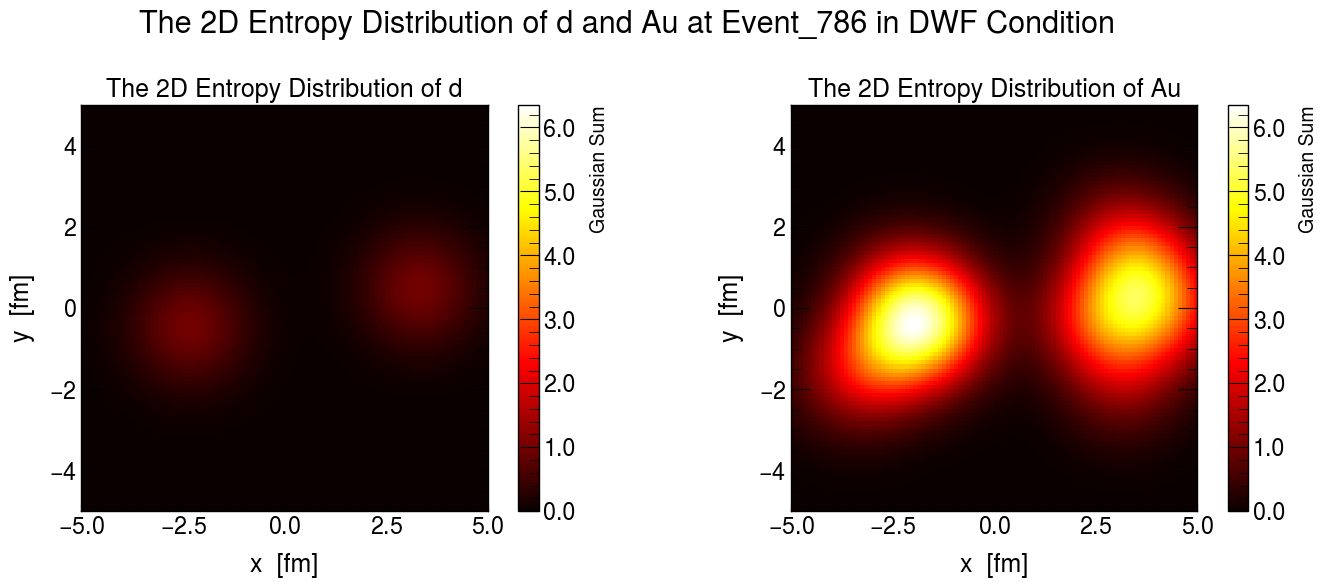

In [14]:
plot_2D_entropy_part(event=786, save_fig='gg', HWF_or_DWF='DWF')

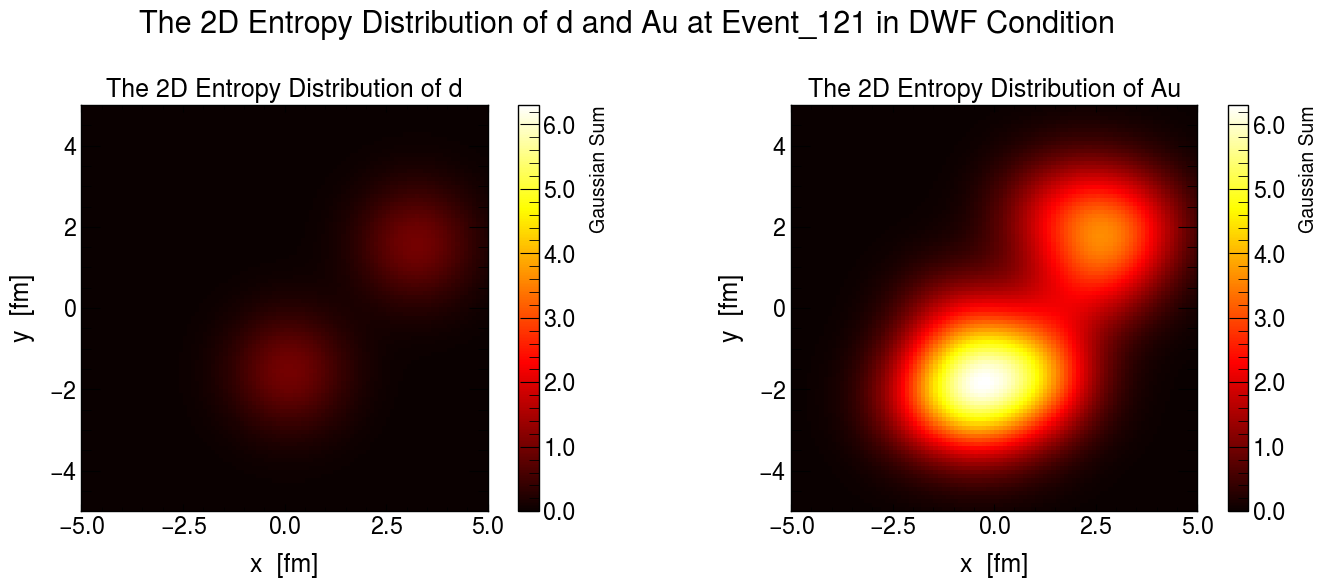

In [15]:
plot_2D_entropy_part(event=121, save_fig='gg', HWF_or_DWF='DWF')

In [16]:
def plot_sub_2D_entropy_part(events_list, save_fig='false', HWF_or_DWF='HWF'):
    # Create output base path
    output_base_path = f'/home/mengzhu/mywork/d_Au_work/fig/'
    
    # 设置字体大小
    title_fontsize = 40
    label_fontsize = 25
    tick_fontsize = 25
    cbar_fontsize = 25
    
    # 创建子图网格 (2行，列数为事件数)
    n_cols = len(events_list)
    fig, axes = plt.subplots(2, n_cols, figsize=(8*n_cols, 12))
    
    # 如果只有一个事件，将axes转换为2D数组
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置范围参数
    original_range = [-10, 10]
    desired_range = [-5, 5]
    original_size = 200
    desired_size = int((desired_range[1] - desired_range[0]) / 
                      ((original_range[1] - original_range[0]) / original_size))
    start_idx = int((desired_range[0] - original_range[0]) / 
                    ((original_range[1] - original_range[0]) / original_size))
    end_idx = start_idx + desired_size
    
    # 遍历每个事件
    for col, event in enumerate(events_list):
        # 计算当前事件的熵
        target_result, proj_result = calculate_2D_entropy(event=event,  sigma=1.0, HWF_or_DWF=HWF_or_DWF)
        
        # 提取所需范围的数据
        proj_result = proj_result[start_idx:end_idx, start_idx:end_idx]
        target_result = target_result[start_idx:end_idx, start_idx:end_idx]
        
        # 计算颜色范围
        global_min = min(proj_result.min(), target_result.min())
        global_max = max(proj_result.max(), target_result.max())
        
        # 绘制d核的图（第一行）
        c1 = axes[0, col].imshow(proj_result, extent=desired_range * 2, 
                                cmap='hot', aspect='auto',  vmin=global_min, vmax=global_max)
        cbar1 = fig.colorbar(c1, ax=axes[0, col], label='Gaussian Sum', format='%.1f')
        
        # 设置d核图的字体大小
        axes[0, col].set_title(f'Event {event}',  fontsize=label_fontsize)
        axes[0, col].set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
        axes[0, col].tick_params(axis='both', labelsize=tick_fontsize)
        cbar1.ax.tick_params(labelsize=cbar_fontsize)
        cbar1.set_label('Gaussian Sum', fontsize=cbar_fontsize)
        axes[0, col].set_aspect('equal')
        
        axes[0, col].text(-4, 3.5, 'd', fontsize=label_fontsize, color='white', weight='bold')

        # 去掉第一行的横坐标刻度
        axes[0, col].set_xticklabels([])

        
        # 绘制Au核的图（第二行）
        c2 = axes[1, col].imshow(target_result, extent=desired_range * 2, 
                                cmap='hot', aspect='auto',  vmin=global_min, vmax=global_max)
        cbar2 = fig.colorbar(c2, ax=axes[1, col], label='Gaussian Sum', format='%.1f')
        
        # 设置Au核图的字体大小
        axes[1, col].set_xlabel('x  [fm]', fontsize=label_fontsize, ha='center')
        axes[1, col].set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
        axes[1, col].tick_params(axis='both', labelsize=tick_fontsize)
        cbar2.ax.tick_params(labelsize=cbar_fontsize)
        cbar2.set_label('Gaussian Sum', fontsize=cbar_fontsize)
        axes[1, col].set_aspect('equal')
        
        axes[1, col].text(-4, 3.5, 'Au', fontsize=label_fontsize, color='white', weight='bold')
        
    
    # 调整布局和标题
    plt.tight_layout(rect=[0.02, 0, 0.98, 0.93], h_pad=-1.0, w_pad=0.5)  # 将h_pad调整为0.5，减小行间距
    plt.suptitle(f'Participants Distribution of d and Au in {HWF_or_DWF} Condition', 
                 fontsize=title_fontsize, y=0.98)
    
    # 保存图像
    if save_fig in {'true', 'True'}:
        ensure_directory_exists(output_base_path)
        heatmap_out_path = os.path.join(output_base_path, 
         f'heatmap_sub_events_{"-".join(map(str, events_list))}_of_d_and_Au_in_{HWF_or_DWF}_condition_part.pdf')
        plt.savefig(heatmap_out_path)
    
    # 显示图像
    plt.show()


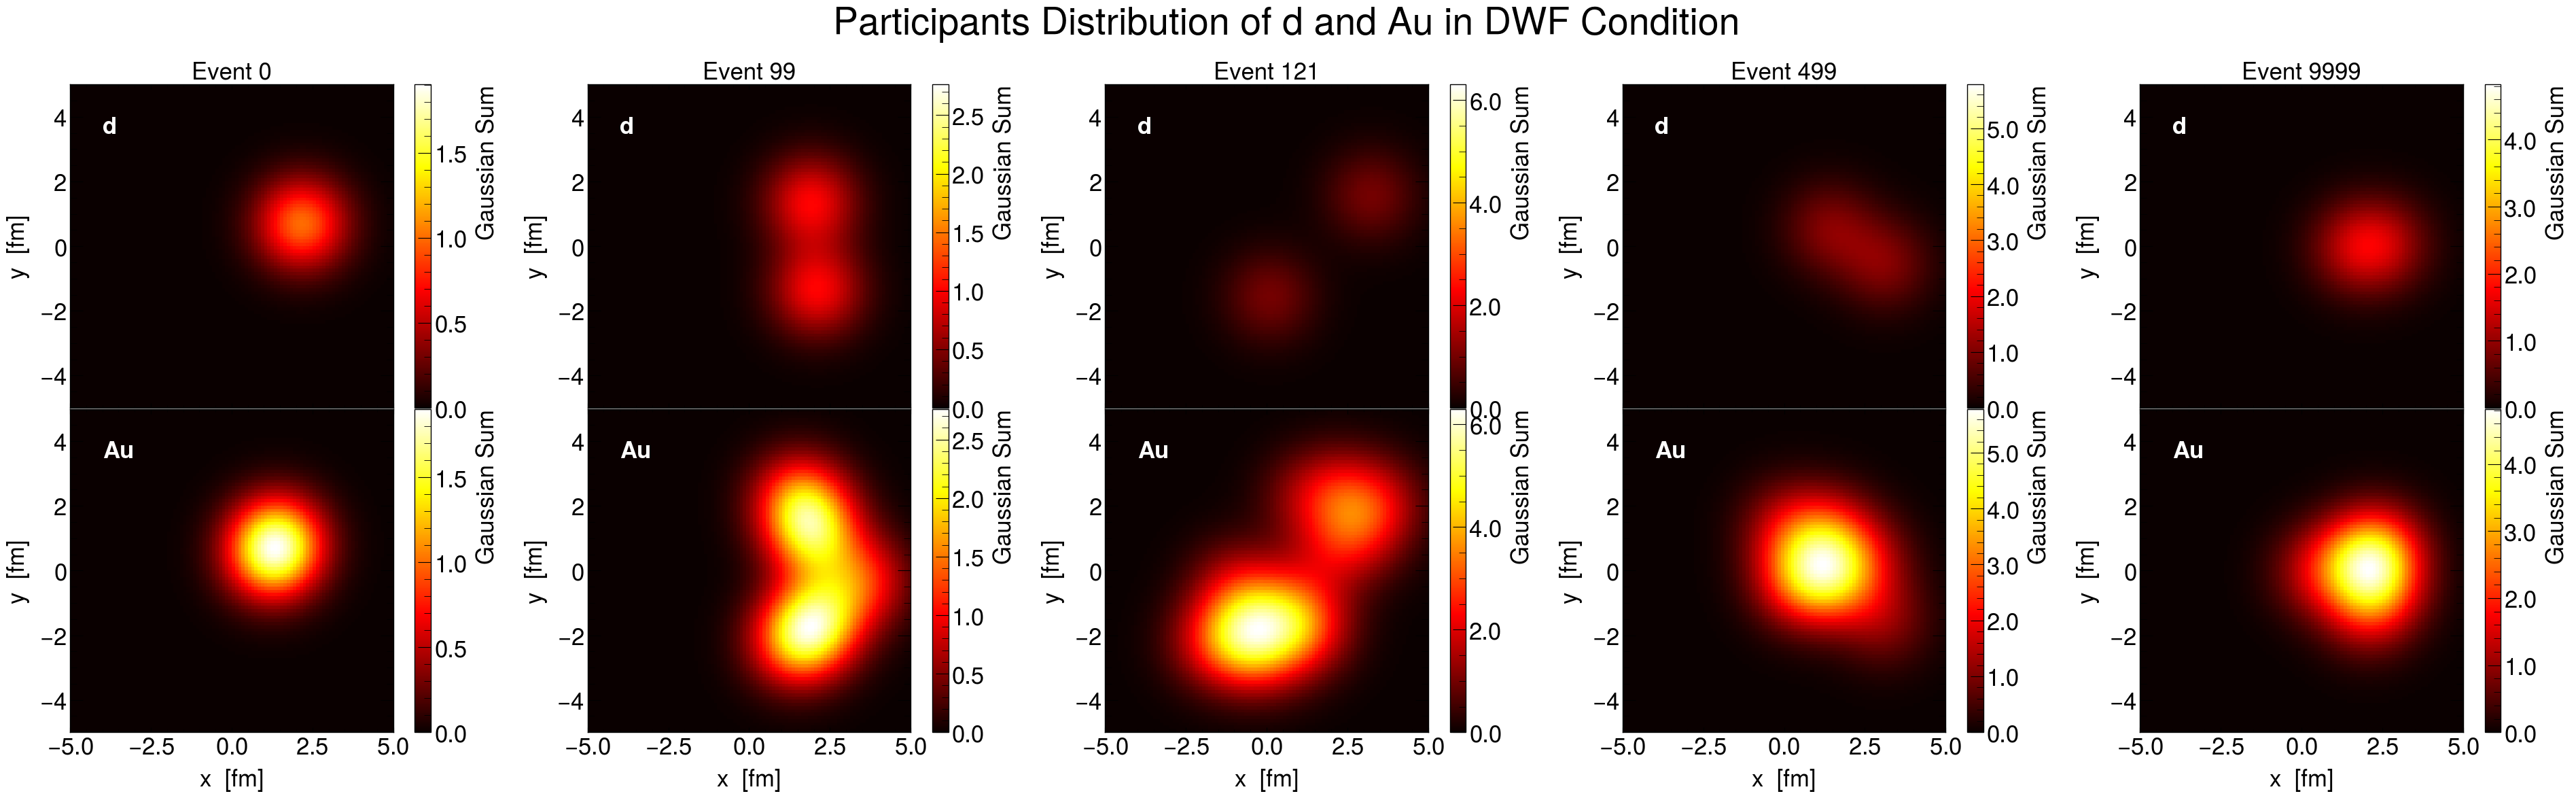

In [17]:
plot_sub_2D_entropy_part(events_list=[0,99,121,499,9999], save_fig='gg', HWF_or_DWF='DWF')

In [18]:
def plot_sub_2D_entropy_part2(events_list, save_fig=False, HWF_or_DWF='HWF'):
    # Create output base path
    output_base_path = f'/home/mengzhu/mywork/d_Au_work/fig/'
    
    # 设置字体大小
    title_fontsize = 50
    label_fontsize = 40
    tick_fontsize = 35
    cbar_fontsize = 35
    
    # 创建子图网格 (2行，列数为事件数)
    n_cols = len(events_list)
    fig, axes = plt.subplots(2, n_cols, figsize=(8.5*n_cols, 15))
    
    # 如果只有一个事件，将axes转换为2D数组
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置范围参数
    original_range = [-10, 10]
    desired_range = [-5, 5]
    original_size = 200
    desired_size = int((desired_range[1] - desired_range[0]) / 
                      ((original_range[1] - original_range[0]) / original_size))
    start_idx = int((desired_range[0] - original_range[0]) / 
                    ((original_range[1] - original_range[0]) / original_size))
    end_idx = start_idx + desired_size
    
    # 初始化全局最小值和最大值
    global_min = np.inf
    global_max = -np.inf
    
    # 遍历每个事件
    for col, event in enumerate(events_list):
        # 计算当前事件的熵
        target_result, proj_result = calculate_2D_entropy(event=event,  sigma=1.0, HWF_or_DWF=HWF_or_DWF)
        
        # 提取所需范围的数据
        proj_result = proj_result[start_idx:end_idx, start_idx:end_idx]
        target_result = target_result[start_idx:end_idx, start_idx:end_idx]
        
        # 更新全局最小值和最大值
        global_min = min(global_min, proj_result.min(), target_result.min())
        global_max = max(global_max, proj_result.max(), target_result.max())
    
    # 遍历每个事件并绘制图像
    for col, event in enumerate(events_list):
        # 计算当前事件的熵
        target_result, proj_result = calculate_2D_entropy(event=event,  sigma=1.0, HWF_or_DWF=HWF_or_DWF)
        
        # 提取所需范围的数据
        proj_result = proj_result[start_idx:end_idx, start_idx:end_idx]
        target_result = target_result[start_idx:end_idx, start_idx:end_idx]
        
        # 绘制d核的图（第一行）
        c1 = axes[0, col].imshow(proj_result, extent=desired_range * 2, 
                                cmap='hot', aspect='auto',  vmin=global_min, vmax=global_max)
        
        # 设置d核图的字体大小
        axes[0, col].set_title(f'Event {event}',  fontsize=label_fontsize)
        if col == 0:  # 只显示第一列的纵坐标
            axes[0, col].set_xticklabels([])
            axes[0, col].set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
#             axes[0, col].set_yticks(np.linspace(desired_range[0], desired_range[1], num=5))
            axes[0, col].tick_params(axis='both', labelsize=tick_fontsize)
            axes[0, col].set_aspect('equal')
            
        else:
            axes[0, col].set_yticklabels([])  # 隐藏其他列的纵坐标
        
            # 隐藏第一行的所有横坐标标签和刻度
            axes[0, col].set_xticklabels([])
            axes[0, col].tick_params(axis='x', labelsize=tick_fontsize)
            axes[0, col].set_xticks([-4, -2, 0, 2, 4])  # 设置横坐标刻度
            axes[0, col].set_aspect('equal')
        
        axes[0, col].text(-4, 3.5, 'd', fontsize=label_fontsize, color='white', weight='bold')
        
        # 绘制Au核的图（第二行）
        c2 = axes[1, col].imshow(target_result, extent=desired_range * 2, 
                                cmap='hot', aspect='auto',  vmin=global_min, vmax=global_max)
        
        # 设置Au核图的字体大小
        if col == 0:  # 只显示第一列的纵坐标
            axes[1, col].set_xlabel('x  [fm]', fontsize=label_fontsize, ha='center')
            axes[1, col].set_xticks([-4, -2, 0, 2, 4])  # 设置横坐标刻度
            axes[1, col].set_ylabel('y  [fm]', fontsize=label_fontsize, ha='center')
#             axes[1, col].set_yticks(np.linspace(desired_range[0], desired_range[1], num=5))
            axes[1, col].tick_params(axis='both', labelsize=tick_fontsize)
            axes[1, col].set_aspect('equal')
        else:
            axes[1, col].set_xlabel('x  [fm]', fontsize=label_fontsize, ha='center')
            axes[1, col].set_xticks([-4, -2, 0, 2, 4])  # 设置横坐标刻度
            axes[1, col].set_yticklabels([])  # 隐藏其他列的纵坐标
#             axes[1, col].set_xticks(np.linspace(desired_range[0], desired_range[1], num=5))  # 设置横坐标
#             axes[1, col].set_xticklabels([f'{x:.1f}' for x in np.linspace(desired_range[0], desired_range[1], num=5)])
            axes[1, col].tick_params(axis='both', labelsize=tick_fontsize)
            axes[1, col].set_aspect('equal')
        
        axes[1, col].text(-4, 3.5, 'Au', fontsize=label_fontsize, color='white', weight='bold')
    
    # 调整布局和标题
    plt.tight_layout(rect=[0.05, 0, 0.90, 0.95], h_pad=-2.2, w_pad=0.5)  # 将h_pad调整为0.5，减小行间距
    plt.suptitle(f'Comparison of d and Au Participating Nucleon Distribution under {HWF_or_DWF} Condition', 
                 fontsize=title_fontsize, x=0.5,y=1)
    
    # 创建共享的颜色条
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # 调整颜色条的位置和大小
#     fig.colorbar(c1, cax=cbar_ax, label='Gaussian Sum', format='%.1f')
    fig.colorbar(c1, cax=cbar_ax, label='Gaussian Sum', format='%d')
    
    
    # 设置颜色条的字体大小
    cbar_ax.tick_params(labelsize=cbar_fontsize)
    cbar_ax.set_ylabel('Gaussian Sum', fontsize=cbar_fontsize)
    
    # 保存图像
    if save_fig:
        ensure_directory_exists(output_base_path)
        heatmap_out_path = os.path.join(output_base_path, 
         f'heatmap_sub_events_{"-".join(map(str, events_list))}_of_d_and_Au_in_{HWF_or_DWF}_condition_part.pdf')
        plt.savefig(heatmap_out_path)
    
    # 显示图像
    plt.show()


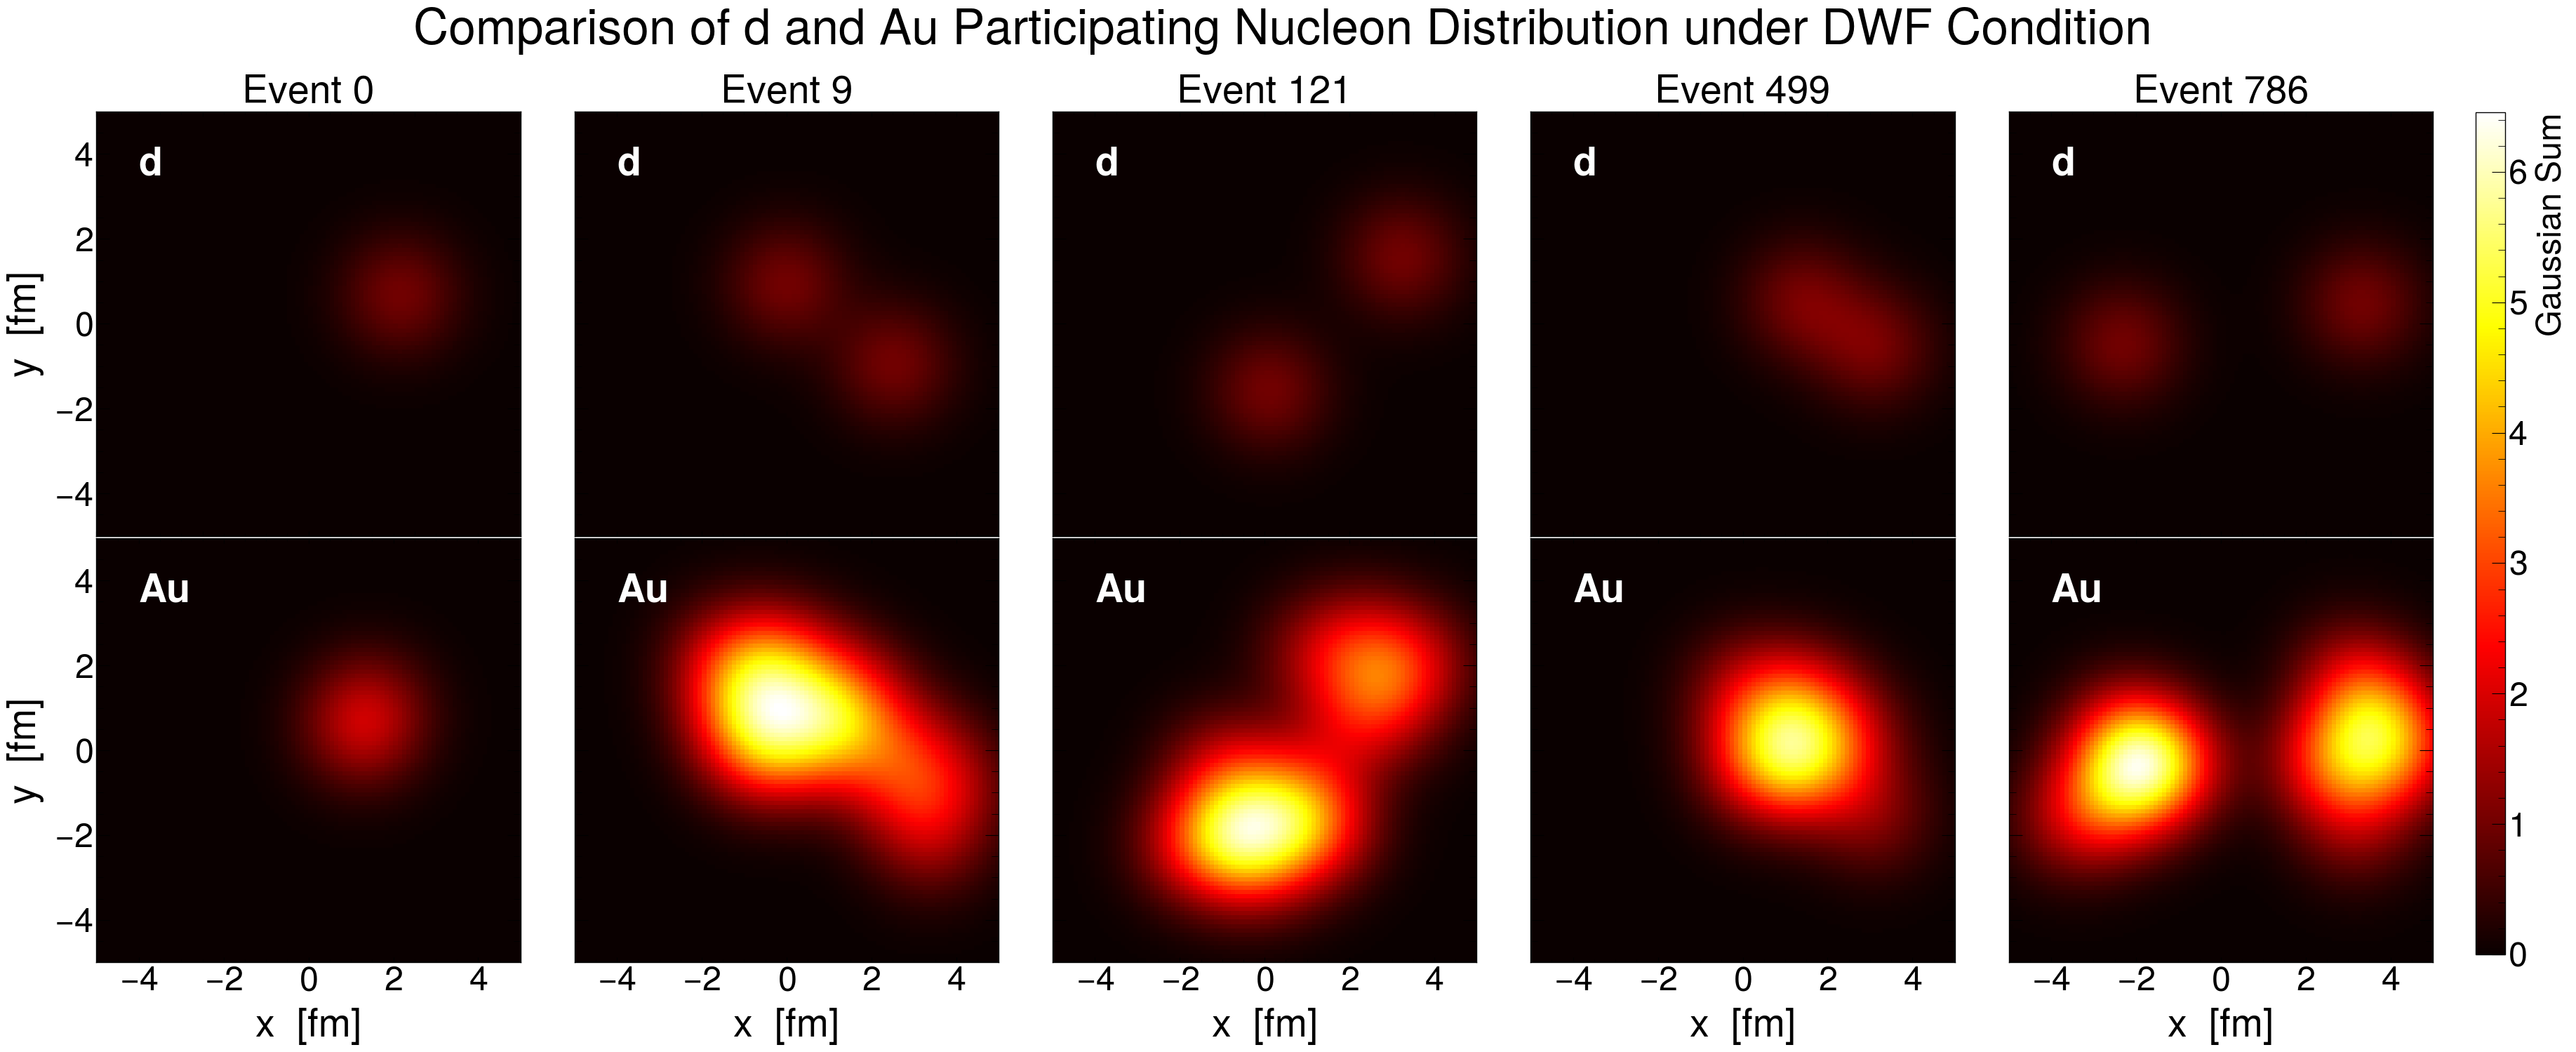

In [23]:
# 示例调用
plot_sub_2D_entropy_part2(events_list=[0,9,121,499, 786], save_fig=True, HWF_or_DWF='DWF')

In [20]:
class GaussianEntropyCalculator:
    def __init__(self, event=0, sigma=1.0, HWF_or_DWF='HWF'):
        self.event = event
        self.sigma = sigma
        self.HWF_or_DWF = HWF_or_DWF
        self.grid_size = 200
        self.input_base_path = f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/information_of_d_Au_collision/event_{event}'
        self.output_base_path = f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/fig/'

    def gaussian_sum(self, x_l, xi_list, sigma, distance_threshold=5):
        sum_value = 0
        for xi in xi_list:
            distance = np.linalg.norm(x_l - xi)
            if distance <= distance_threshold:
                sum_value += np.exp(-np.sum((x_l - xi)**2) / (2 * sigma**2))
        return sum_value

    def read_positions(self, file_path):
        data = np.loadtxt(file_path)
        if data.ndim == 1:
            data = data.reshape(-1, 2)
        elif data.shape[1] != 2:
            raise ValueError("Each line in the file must contain exactly two values.")
        return [np.array([x, y]) for x, y in data]

    def evaluate_gaussian_sum_on_grid(self, grid_points, xi_list, sigma):
        grid_size = grid_points.shape[0]
        result = np.zeros((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                result[i, j] = self.gaussian_sum(grid_points[i, j], xi_list, sigma)
        return result

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def save_results(self, base_directory, filename, result):
        self.ensure_directory_exists(base_directory)
        filepath = os.path.join(base_directory, filename)
        np.savetxt(filepath, result)
        return filepath

    def calculate_2D_entropy(self):
        target_file_path = os.path.join(self.input_base_path, 'position_of_target.dat')
        proj_file_path = os.path.join(self.input_base_path, 'position_of_projectile.dat')

        target_xi_list = self.read_positions(target_file_path)
        proj_xi_list = self.read_positions(proj_file_path)

        x_range = np.linspace(-10, 10, self.grid_size)
        y_range = np.linspace(-10, 10, self.grid_size)
        x_grid, y_grid = np.meshgrid(x_range, y_range)
        grid_points = np.stack([x_grid, y_grid], axis=-1)

        target_result = self.evaluate_gaussian_sum_on_grid(grid_points, target_xi_list, self.sigma)
        proj_result = self.evaluate_gaussian_sum_on_grid(grid_points, proj_xi_list, self.sigma)

        return x_range, y_range, target_result, proj_result

    def plot_2D_entropy(self, save_fig='false'):
        x_range, y_range, target_result, proj_result = self.calculate_2D_entropy()

        title_fontsize = 22 
        label_fontsize = 18

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        c1 = ax1.imshow(proj_result, cmap='hot', aspect='auto')
        fig.colorbar(c1, ax=ax1, label='Gaussian Sum')
        ax1.set_title('The 2D Entropy Distribution of d', fontsize=label_fontsize)
        ax1.set_xlabel('X', fontsize=label_fontsize, ha='center')
        ax1.set_ylabel('Y', fontsize=label_fontsize, ha='center')
        ax1.set_aspect('equal')

        c2 = ax2.imshow(target_result, cmap='hot', aspect='auto')
        fig.colorbar(c2, ax=ax2, label='Gaussian Sum')
        ax2.set_title('The 2D Entropy Distribution of Au', fontsize=label_fontsize)
        ax2.set_xlabel('X', fontsize=label_fontsize, ha='center')
        ax2.set_ylabel('Y', fontsize=label_fontsize, ha='center')
        ax2.set_aspect('equal')

        plt.tight_layout(rect=[0.05, 0, 0.95, 0.9])
        plt.suptitle(f'The 2D Entropy Distribution of d and Au at Event_{self.event} in {self.HWF_or_DWF} Condition', fontsize=title_fontsize)

        if save_fig.lower() == 'true':
            self.ensure_directory_exists(self.output_base_path)
            heatmap_out_path = os.path.join(self.output_base_path, f'heatmap_event_{self.event}_of_proj_and_target_in_{self.HWF_or_DWF}_condition.pdf')
            plt.savefig(heatmap_out_path)
            print(f'Figure saved at: {heatmap_out_path}')

        plt.show()

    def plot_2D_entropy2(self, save_fig='false'):
        x_range, y_range, target_result, proj_result = self.calculate_2D_entropy()

        title_fontsize = 22 
        label_fontsize = 18

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        c1 = ax1.contourf(x_range, y_range, proj_result, levels=50, cmap='hot')
        fig.colorbar(c1, ax=ax1, label='Gaussian Sum')
        ax1.set_title('The 2D Entropy Distribution of d', fontsize=label_fontsize)
        ax1.set_xlabel('X', fontsize=label_fontsize, ha='center')
        ax1.set_ylabel('Y', fontsize=label_fontsize, ha='center')
        ax1.set_aspect('equal')

        c2 = ax2.contourf(x_range, y_range, target_result, levels=50, cmap='hot')
        fig.colorbar(c2, ax=ax2, label='Gaussian Sum')
        ax2.set_title('The 2D Entropy Distribution of Au', fontsize=label_fontsize)
        ax2.set_xlabel('X', fontsize=label_fontsize, ha='center')
        ax2.set_ylabel('Y', fontsize=label_fontsize, ha='center')
        ax2.set_aspect('equal')

        plt.tight_layout(rect=[0.05, 0, 0.95, 0.9])
        plt.suptitle(f'The 2D Entropy Distribution of d and Au at Event_{self.event} in {self.HWF_or_DWF} Condition', fontsize=title_fontsize)

        if save_fig.lower() == 'true':
            self.ensure_directory_exists(self.output_base_path)
            heatmap_out_path = os.path.join(self.output_base_path, f'heatmap_event_{self.event}_of_proj_and_target_in_{self.HWF_or_DWF}_condition.pdf')
            plt.savefig(heatmap_out_path)
            print(f'Figure saved at: {heatmap_out_path}')

        plt.show()


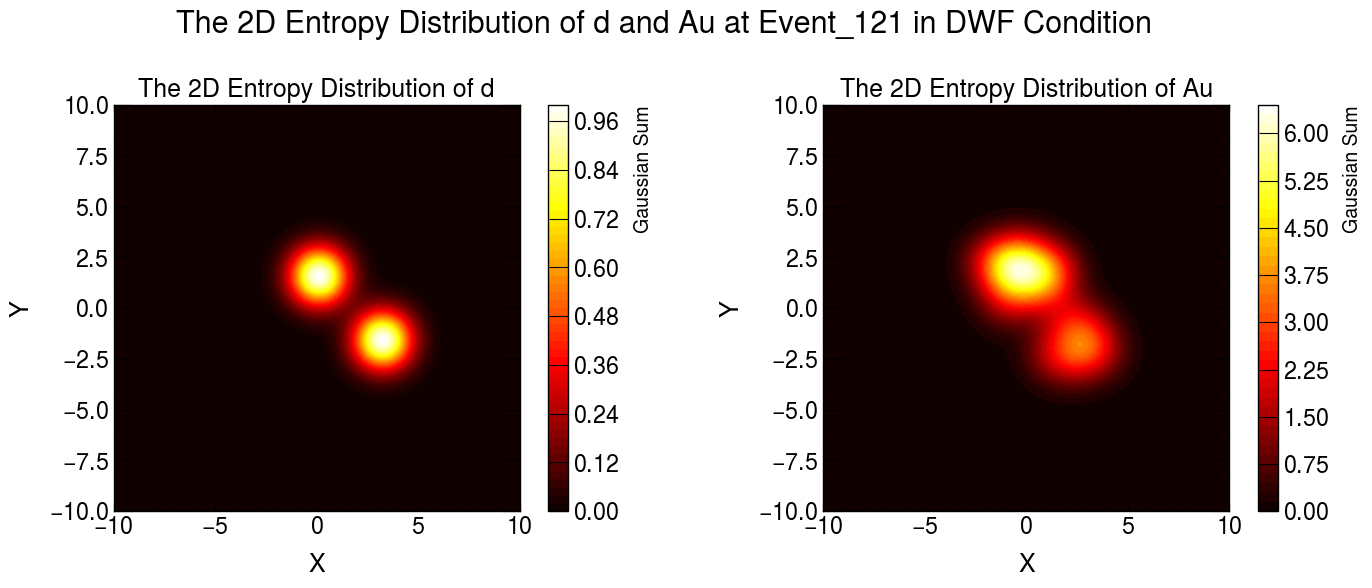

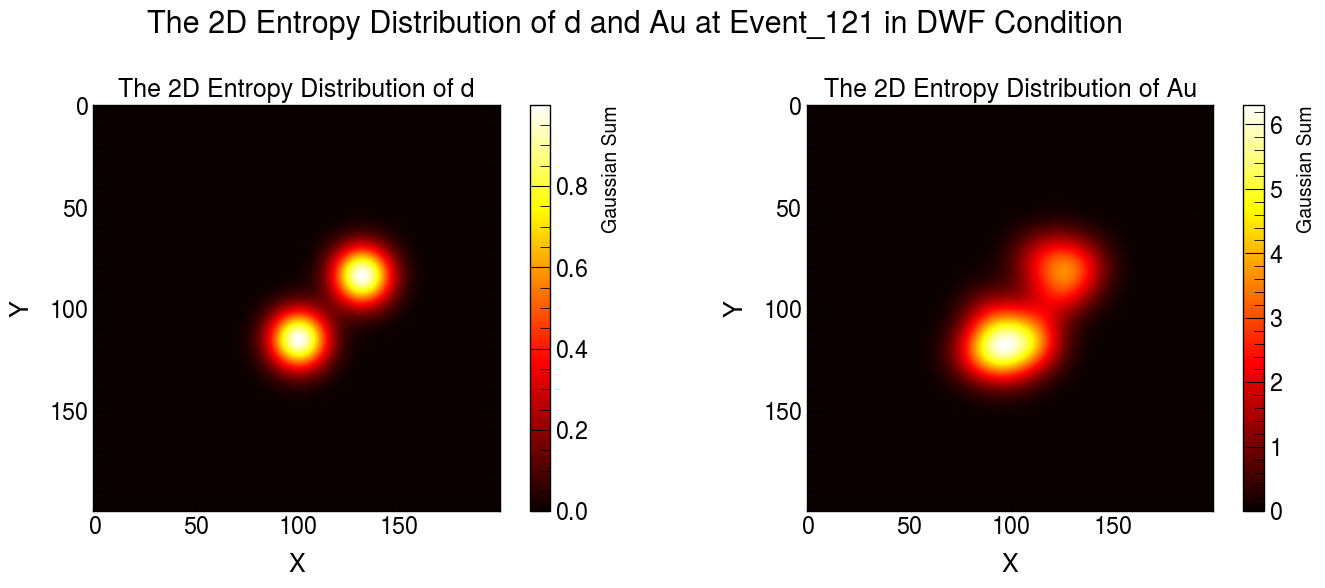

In [21]:
calculator_DWF = GaussianEntropyCalculator(event=121, sigma=1.0,HWF_or_DWF='DWF')
calculator_DWF.plot_2D_entropy2(save_fig='gg')
calculator_DWF.plot_2D_entropy(save_fig='gg')

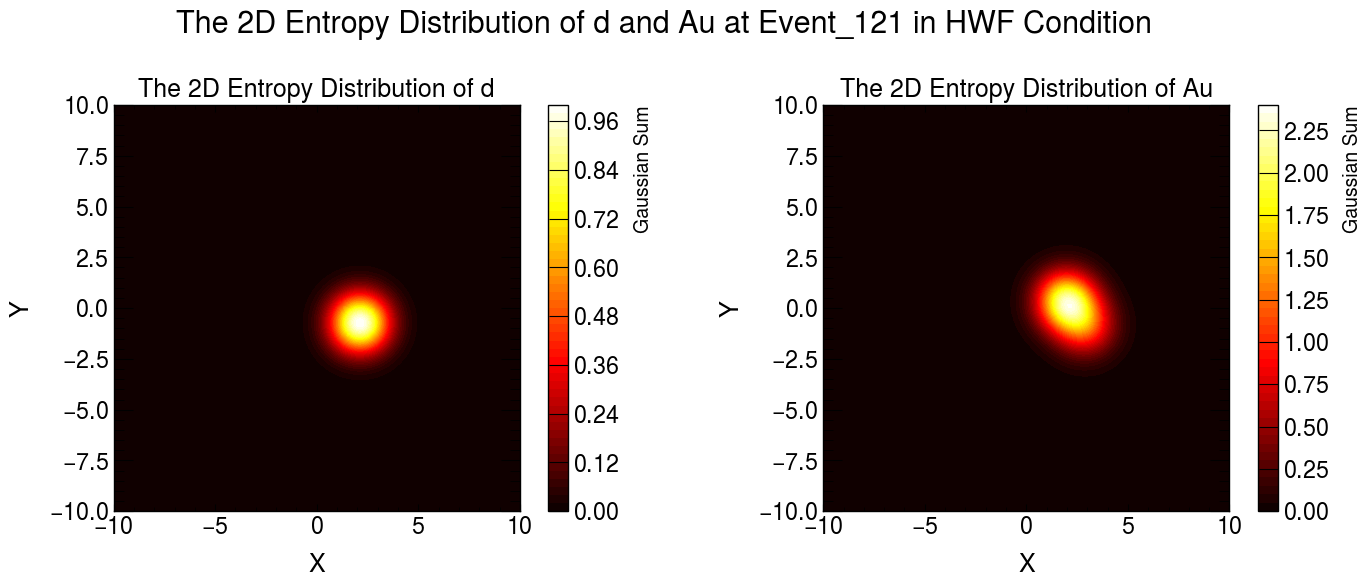

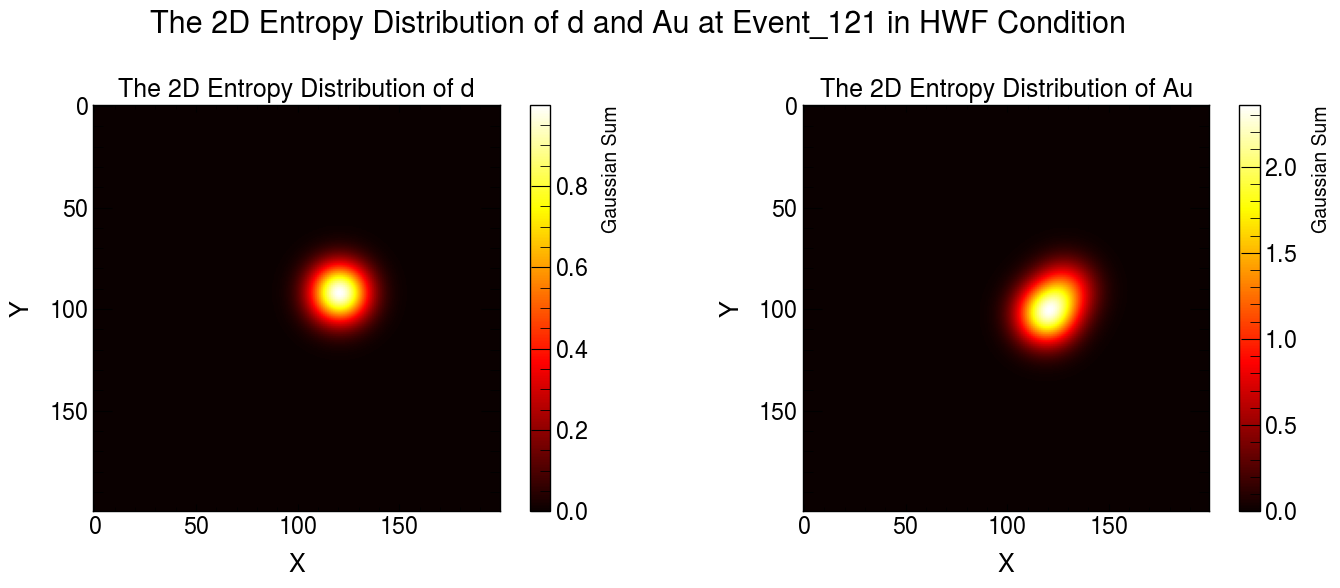

In [22]:
calculator_DWF = GaussianEntropyCalculator(event=121, sigma=1.0,HWF_or_DWF='HWF')
calculator_DWF.plot_2D_entropy2(save_fig='false')
calculator_DWF.plot_2D_entropy(save_fig='false')